## This script tests the PicketFence.to_quaac() method of the pylinac package.

In [1]:
# Environment
#   Windows 10
import platform
import pylinac

print(f"Python: {platform.python_version()}")
print(f"Pylinac: {pylinac.__version__}")

Python: 3.12.0
Pylinac: 3.25.0


In [2]:
from pylinac import PicketFence
from quaac import User, Equipment, Attachment, Document, DataPoint

## Create input for pylinac

In [3]:
pf_img_path = r"H:\quaac_pylinac\tests\integration\fixtures\RI_PicketFence_G0.dcm"
pf = PicketFence(pf_img_path)
pf.analyze()

## Print results

In [4]:
print(pf.results())

Picket Fence Results:
Gantry Angle (°): 0.0
Collimator Angle (°): 0.0
Tolerance (mm): 0.5
Leaves passing (%): 100.0
Absolute median error (mm): 0.022mm
Mean picket spacing (mm): 15.0mmn
Picket offsets from CAX (mm): 59.8 44.8 29.8 14.7 -0.4 -15.5 -30.3 -45.5 -60.6 -75.5
Max Error: 0.107mm on Picket: 8, Leaf: 25
MLC Skew: -0.072 degrees


## Create inputs for QuAAC

In [5]:
pf_image_attachment = Attachment.from_file(pf_img_path)
user = User(name="Luis Olivares", email="luis@phys.com")
equipment = Equipment(name="Clinac-iX", type="Linac", serial_number="123", manufacturer="Varian", model="iX")

## Create QuAAC document as yaml

In [6]:
path = "PicketFence_G0.yaml"
pf.to_quaac(
    path = path,
    format = "yaml",
    performer = user,
    primary_equipment = equipment,
    attachments = [pf_image_attachment],
    overwrite = True,
    )

## Load the yaml file and print content

In [7]:
with open(path) as yaml_file:
    print(yaml_file.read())

version: '1.0'
datapoints:
- name: Leaves passing
  perform datetime: '2024-07-25T08:24:47.915529'
  measurement value: 100.0
  measurement unit: '%'
  reference value: null
  description: The percentage of leaves that passed the tolerance test. A value of
    100% is ideal.
  procedure: ''
  performer: (Luis Olivares) cadce9cc4948d594fc50fd202b46a009
  performer comment: ''
  primary equipment: (Clinac-iX) 5af432b871171775c73aad282edb2f7f
  reviewer: null
  parameters:
    pylinac version: 3.25.0
  ancillary equipment: []
  attachments:
  - (RI_PicketFence_G0.dcm) 29895bd4bc01eeafa02ef5003f8c51f4
  hash: f1cbec37f2e83516c5573506b50d3824
- name: Absolute median error
  perform datetime: '2024-07-25T08:24:47.915529'
  measurement value: 0.02165526807241895
  measurement unit: mm
  reference value: null
  description: The absolute median error of all leaves.
  procedure: ''
  performer: (Luis Olivares) cadce9cc4948d594fc50fd202b46a009
  performer comment: ''
  primary equipment: (Clinac-

## Work with another image (PF with angle gantry 90)

In [8]:
pf_img_path_G90 = r"H:\quaac_pylinac\tests\integration\fixtures\RI_PicketFence_G90.dcm"
pf_G90 = PicketFence(pf_img_path_G90)
pf_G90.analyze()
print(pf_G90.results())

Picket Fence Results:
Gantry Angle (°): 90.0
Collimator Angle (°): 0.0
Tolerance (mm): 0.5
Leaves passing (%): 100.0
Absolute median error (mm): 0.021mm
Mean picket spacing (mm): 15.0mmn
Picket offsets from CAX (mm): 59.4 44.3 29.3 14.2 -0.8 -15.8 -30.9 -45.9 -60.9 -75.9
Max Error: 0.101mm on Picket: 9, Leaf: 31
MLC Skew: -0.127 degrees


## Creating another QuAAC file

In [9]:
path_G90 = "PicketFence_G90.yaml"
pf_image_attachment_G90 = Attachment.from_file(pf_img_path_G90)
pf_G90.to_quaac(
    path = path_G90,
    format = "yaml",
    performer = user,
    primary_equipment = equipment,
    attachments = [pf_image_attachment_G90],
    overwrite = True,
    )

## Merging two Documents

In [10]:
doc1 = Document.from_yaml_file("PicketFence_G0.yaml")
doc2 = Document.from_yaml_file("PicketFence_G90.yaml")

In [11]:
new_doc = doc1.merge([doc2])

## Filtering

In [12]:
# Define a function to get the points by name
def get_points_by_name(doc: Document, name: str) -> list[DataPoint]:
    return [dp for dp in doc.datapoints if dp.name == name]

In [13]:
points = get_points_by_name(new_doc, "Max error")
measurements = [p.measurement_value for p in points]
date = [p.perform_datetime for p in points]

## Plotting

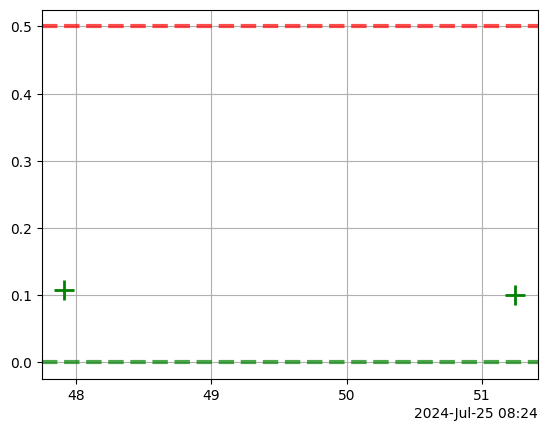

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

ax.plot(date, measurements, "g+", markersize=15, mew=2)

# Show reference and tolerance lines
ax.axhline(0.5, linestyle = "--", linewidth = 3, color = "r", alpha = 0.7)
ax.axhline(0, linestyle = "--", linewidth = 3, color = "g", alpha = 0.7)
ax.grid(which="both")

# Format the date on the x-axis
locator = mdates.AutoDateLocator(maxticks=7)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))